In [2]:
import shutil
import urllib.request as request
from contextlib import closing

# first we download the Sift1M dataset
with closing(request.urlopen('ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz')) as r:
    with open('sift.tar.gz', 'wb') as f:
        shutil.copyfileobj(r, f)

In [3]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 6.8 MB/s eta 0:00:00


In [4]:
import tarfile

# the download leaves us with a tar.gz file, we unzip it
tar = tarfile.open('sift.tar.gz', "r:gz")
tar.extractall()

In [5]:
import numpy as np

# now define a function to read the fvecs file format of Sift1M dataset
def read_fvecs(fp):
    a = np.fromfile(fp, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy().view('float32')

In [6]:
# data we will search through
xb = read_fvecs('./sift/sift_base.fvecs')  # 1M samples
# also get some query vectors to search with
xq = read_fvecs('./sift/sift_query.fvecs')
# take just one query (there are many in sift_learn.fvecs)
xq = xq[0].reshape(1, xq.shape[1])

In [7]:
xq.shape

(1, 128)

In [8]:
xb.shape

(1000000, 128)





**Benchmarking Algorithms**

In [9]:
import time
import sys
import numpy as np
import faiss

try:
    from faiss.contrib.datasets_fb import DatasetSIFT1M
except ImportError:
    from faiss.contrib.datasets import DatasetSIFT1M

In [11]:
def get_data(size=10**5):
  ds = DatasetSIFT1M()
  xq = ds.get_queries()[:size, :]
  xb = ds.get_database()[:size, :]
  gt = ds.get_groundtruth()[:size, :]
  # xt = ds.get_train()

  return xb, xq, gt


def evaluate(index):
    import time
    # for timing with a single core
    # faiss.omp_set_num_threads(1)
    t0 = time.time()
    D, I = index.search(xq, k)
    #print(I)
    t1 = time.time()


    missing_rate = (I == -1).sum() / float(k * nq)
    recall_at_1 = (I[:,:1] == gt[:, :1]).sum() / float(nq)
    print("\t %7.3f ms, R@1 %.4f, missing rate %.4f" % (
        (t1 - t0) * 1000.0, recall_at_1, missing_rate))
    return (t1 - t0) * 1000.0 , recall_at_1


In [19]:
times = []
recall=[]
algorithms = ['flatl2', 'flatip', 'ivf', 'pq', 'hnsw']
execution_time = {'flatl2':[], 'flatip':[], 'ivf':[], 'pq':[], 'hnsw':[] }
recall_at_1 = {'flatl2':[], 'flatip':[], 'ivf':[], 'pq':[], 'hnsw':[] }

for size in [10000, 100000, 1000000]:
  xb, xq, gt = get_data(size=size)
  nq, d = xq.shape
  k = 4

  if 'flatl2' in algorithms:
    index = faiss.IndexFlatL2(d)
    print("flatl2")
    # to see progress
    index.verbose = True
    index.add(xb)
    t, r= evaluate(index)
    execution_time['flatl2'].append(np.around(t, 3))
    recall_at_1['flatl2'].append(np.around(r, 3))

  if 'flatip' in algorithms:
    index = faiss.IndexFlatIP(d)
    print("flatip")
    # to see progress
    index.verbose = True
    index.add(xb)
    t, r= evaluate(index)
    execution_time['flatip'].append(np.around(t, 3))
    recall_at_1['flatip'].append(np.around(r, 3))

  if 'ivf' in algorithms:
    print("ivf")
    nlist = 128  # number of cells/clusters to partition data into
    quantizer = faiss.IndexFlatIP(d)  # how the vectors will be stored/compared
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    index.train(xb)  # we must train the index to cluster into cells
    index.add(xb)
    index.nprobe = 8  # set how many of nearest cells to search
    t, r= evaluate(index)
    execution_time['ivf'].append(np.around(t, 3))
    recall_at_1['ivf'].append(np.around(r, 3))

  if 'pq' in algorithms:
    print("pq")
    nbits = m = 8  # number of bits per subquantizer, k* = 2**nbits
    index = faiss.IndexPQ(d, m, nbits)
    index.train(xb)
    index.add(xb)
    t, r= evaluate(index)
    execution_time['pq'].append(np.around(t, 3))
    recall_at_1['pq'].append(np.around(r, 3))

  if 'hnsw' in algorithms:
    print("hnsw")
    M = 64  # number of connections each vertex will have
    ef_search = 32  # depth of layers explored during search
    ef_construction = 32  # depth of layers explored during index construction
    # initialize index (d == 128)
    index = faiss.IndexHNSWFlat(d, M)
    # set efConstruction and efSearch parameters
    index.hnsw.efConstruction = ef_construction
    index.hnsw.efSearch = ef_search
    # add data to index
    index.add(xb)
    t, r= evaluate(index)
    execution_time['hnsw'].append(np.around(t, 3))
    recall_at_1['hnsw'].append(np.around(r, 3))




flatl2
	 1633.288 ms, R@1 0.0143, missing rate 0.0000
flatip
	 1574.417 ms, R@1 0.0139, missing rate 0.0000
ivf
	 365.442 ms, R@1 0.0140, missing rate 0.0000
pq
	 1047.015 ms, R@1 0.0104, missing rate 0.0000
hnsw
	 886.156 ms, R@1 0.0143, missing rate 0.0000
flatl2
	 8822.288 ms, R@1 0.1089, missing rate 0.0000
flatip
	 6789.946 ms, R@1 0.1052, missing rate 0.0000
ivf
	 5825.834 ms, R@1 0.1072, missing rate 0.0000
pq
	 6744.356 ms, R@1 0.0496, missing rate 0.0000
hnsw
	 1757.262 ms, R@1 0.1088, missing rate 0.0000
flatl2
	 79247.963 ms, R@1 0.9914, missing rate 0.0000
flatip
	 72409.941 ms, R@1 0.8835, missing rate 0.0000
ivf
	 69504.081 ms, R@1 0.9783, missing rate 0.0000
pq
	 58996.537 ms, R@1 0.2240, missing rate 0.0000
hnsw
	 3512.783 ms, R@1 0.9625, missing rate 0.0000
flatl2
	 78060.430 ms, R@1 0.9914, missing rate 0.0000
flatip
	 70435.901 ms, R@1 0.8835, missing rate 0.0000
ivf
	 72120.011 ms, R@1 0.9783, missing rate 0.0000
pq
	 59322.002 ms, R@1 0.2240, missing rate 0.0000
hn

In [ ]:
# execution_time['hnsw'] = np.around(times, 3)
# recall_at_1['hnsw'] = np.around(recall, 3)

In [26]:
recall_at_1

{'flatl2': [0.014, 0.109, 0.991, 0.991],
 'flatip': [0.014, 0.105, 0.884, 0.884],
 'ivf': [0.014, 0.107, 0.978, 0.978],
 'pq': [0.01, 0.05, 0.224, 0.224],
 'hnsw': [0.014, 0.109, 0.962, 0.965]}

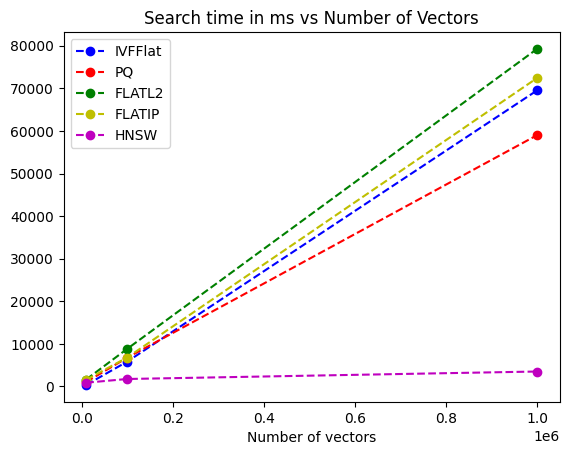

In [32]:
import matplotlib.pyplot as plt
plt.plot([10000, 100000, 1000000], execution_time['ivf'][:3], linestyle='--', marker='o', color='b', label='IVFFlat')
plt.plot([10000, 100000, 1000000], execution_time['pq'][:3], linestyle='--', marker='o', color='r', label='PQ')
plt.plot([10000, 100000, 1000000], execution_time['flatl2'][:3], linestyle='--', marker='o', color='g', label='FLATL2')
plt.plot([10000, 100000, 1000000], execution_time['flatip'][:3], linestyle='--', marker='o', color='y', label='FLATIP')
plt.plot([10000, 100000, 1000000], execution_time['hnsw'][:3], linestyle='--', marker='o', color='m', label='HNSW')
plt.xlabel('Number of vectors', fontsize=10)
plt.title('Search time in ms vs Number of Vectors', fontsize=12)

plt.legend()

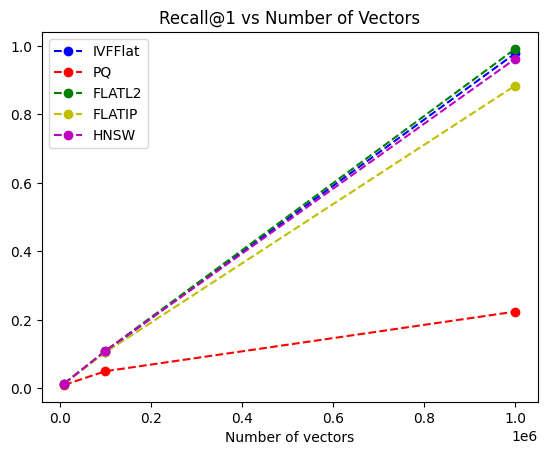

In [34]:
plt.plot([10000, 100000, 1000000], recall_at_1['ivf'][:3], linestyle='--', marker='o', color='b', label='IVFFlat')
plt.plot([10000, 100000, 1000000], recall_at_1['pq'][:3], linestyle='--', marker='o', color='r', label='PQ')
plt.plot([10000, 100000, 1000000], recall_at_1['flatl2'][:3], linestyle='--', marker='o', color='g', label='FLATL2')
plt.plot([10000, 100000, 1000000], recall_at_1['flatip'][:3], linestyle='--', marker='o', color='y', label='FLATIP')
plt.plot([10000, 100000, 1000000], recall_at_1['hnsw'][:3], linestyle='--', marker='o', color='m', label='HNSW')
plt.xlabel('Number of vectors', fontsize=10)
plt.title('Recall@1 vs Number of Vectors', fontsize=12)
plt.legend()


In [35]:
import pandas as pd
pd.DataFrame(execution_time).T

,0,1,2,3
flatl2,1633.288,8822.288,79247.963,78060.430
flatip,1574.417,6789.946,72409.941,70435.901
ivf,365.442,5825.834,69504.081,72120.011
pq,1047.015,6744.356,58996.537,59322.002
hnsw,886.156,1757.262,3512.783,3176.254


In [36]:
pd.DataFrame(recall_at_1).T

,0,1,2,3
flatl2,0.014,0.109,0.991,0.991
flatip,0.014,0.105,0.884,0.884
ivf,0.014,0.107,0.978,0.978
pq,0.010,0.050,0.224,0.224
hnsw,0.014,0.109,0.962,0.965
